In [1]:
import os
import shutil
import re
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
import copy
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [4]:
root_dir = "/content/gdrive/My Drive/Colab Notebooks/melanoma_classification/siim-isic-melanoma-classification/jpeg/"
print("The data lies here =>", root_dir)

The data lies here => /content/gdrive/My Drive/Colab Notebooks/melanoma_classification/siim-isic-melanoma-classification/jpeg/


In [5]:
# Make transforms and use data loaders

# We'll use these a lot, so make them variables
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [6]:
melanoma_dataset = {x: datasets.ImageFolder(os.path.join(root_dir, x),
  chosen_transforms[x])
                  for x in ['train', 'test']}

In [7]:
melanoma_dataset

{'test': Dataset ImageFolder
     Number of datapoints: 874
     Root location: /content/gdrive/My Drive/Colab Notebooks/melanoma_classification/siim-isic-melanoma-classification/jpeg/test
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=3)
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'train': Dataset ImageFolder
     Number of datapoints: 4389
     Root location: /content/gdrive/My Drive/Colab Notebooks/melanoma_classification/siim-isic-melanoma-classification/jpeg/train
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=3)
                RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomRotation(degrees=(-15, 15), resample=False, expand=F

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(melanoma_dataset[x], batch_size=1,
  shuffle=True, num_workers=4)
              for x in ['train', 'test']}

In [9]:
dataset_sizes = {x: len(melanoma_dataset[x]) for x in ['train', 'test']}
class_names = melanoma_dataset['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [11]:
class_names

['benign', 'malignant']

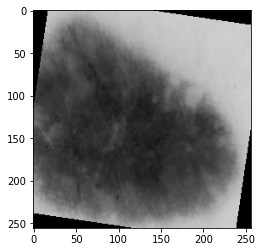

In [12]:
inputs, classes = next(iter(melanoma_dataset['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [13]:
res_mod = models.resnet34(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 2)


In [14]:
for name, child in res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [15]:
res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [17]:
def visualize_model(model, num_images=20):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/9
----------
Iterating through data...
train Loss: 0.7911 Acc: 0.5028
Iterating through data...
test Loss: 0.6997 Acc: 0.5240

Epoch 1/9
----------
Iterating through data...
train Loss: 0.6885 Acc: 0.5815
Iterating through data...
test Loss: 0.9584 Acc: 0.5229

Epoch 2/9
----------
Iterating through data...
train Loss: 0.6481 Acc: 0.6443
Iterating through data...
test Loss: 0.7496 Acc: 0.5160

Epoch 3/9
----------
Iterating through data...
train Loss: 0.6200 Acc: 0.6628
Iterating through data...
test Loss: 0.7499 Acc: 0.5172

Epoch 4/9
----------
Iterating through data...
train Loss: 0.6027 Acc: 0.6858
Iterating through data...
test Loss: 1.1652 Acc: 0.4863

Epoch 5/9
----------
Iterating through data...
train Loss: 0.5927 Acc: 0.6908
Iterating through data...
test Loss: 0.8552 Acc: 0.5389

Epoch 6/9
----------
Iterating through data...
train Loss: 0.5209 Acc: 0.7368
Iterating through data...
test Loss: 0.9260 Acc: 0.5503

Epoch 7/9
----------
Iterating through data...
train Lo

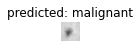

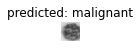

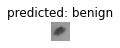

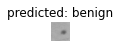

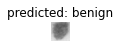

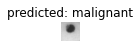

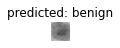

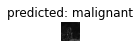

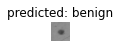

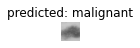

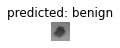

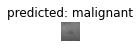

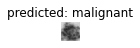

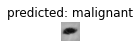

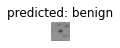

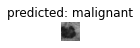

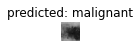

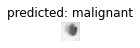

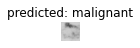

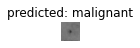

In [18]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
visualize_model(base_model)
plt.show()

In [19]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
  for inputs, labels in tqdm(dataloaders['test']):
    inputs, labels = inputs.to(device), labels.to(device) #x_batch, y_batch
    outputs = base_model(inputs) #y_test_pred
    _, preds = torch.max(outputs, 1) #y_pred_tag
    y_pred_list.append(preds.cpu().numpy())
    y_true_list.append(labels.cpu().numpy())

#
# with torch.no_grad():
#     for x_batch, y_batch in tqdm(test_loader):
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         y_test_pred = model(x_batch)
#         y_test_pred = torch.log_softmax(y_test_pred, dim=1)
#         _, y_pred_tag = torch.max(y_test_pred, dim = 1)
#         y_pred_list.append(y_pred_tag.cpu().numpy())
#         y_true_list.append(y_batch.cpu().numpy())


In [20]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [21]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.61      0.35      0.44       417
           1       0.57      0.79      0.67       457

    accuracy                           0.58       874
   macro avg       0.59      0.57      0.55       874
weighted avg       0.59      0.58      0.56       874



In [22]:
print(confusion_matrix(y_true_list, y_pred_list))


[[146 271]
 [ 94 363]]


In [23]:
melanoma_dataset['train'].class_to_idx

{'benign': 0, 'malignant': 1}

In [24]:
idx2class = {v: k for k, v in melanoma_dataset['train'].class_to_idx.items()}

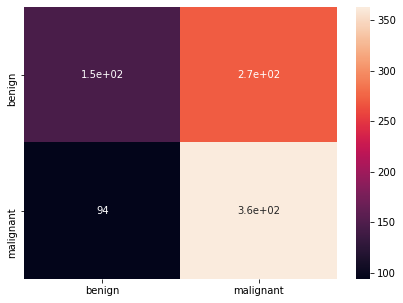

In [25]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [27]:
model_save_name = 'res34_melanoma_classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(base_model, path)